# Import Modules

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

# Import Dataset

In [28]:
df = pd.read_csv("movies_new.csv")
df = df.sort_values(by="startYear")
df.drop(columns=["originalTitle"], inplace=True)
print(f"Features: {df.columns}")
print(f"Shape: {df.shape}")

Features: Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'HitScore'],
      dtype='object')
Shape: (199595, 10)


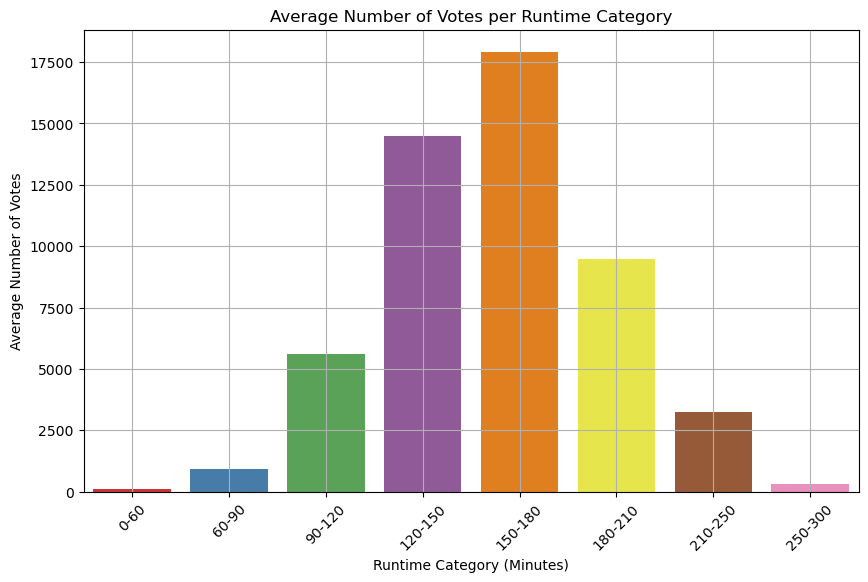

In [29]:

df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')


# Define bins for runtimes
bins = [0, 60, 90, 120, 150, 180, 210, 250, 300]
bin_labels = ['0-60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-250', '250-300']

# Add a column for runtime categories
df['runtime_category'] = pd.cut(df['runtimeMinutes'], bins=bins, labels=bin_labels)

# Group by runtime categories and calculate the mean number of votes in each category
runtime_vote_group = df.groupby('runtime_category', observed=False)['numVotes'].mean().reset_index()

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=runtime_vote_group, x='runtime_category', y='numVotes', palette='Set1', hue=bin_labels)  # Set hue=None to silence warning
plt.title('Average Number of Votes per Runtime Category')
plt.xlabel('Runtime Category (Minutes)')
plt.ylabel('Average Number of Votes')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## Data Preprocessing 

#### Feature Engineering

In [30]:
# Convert to list
df['genres'] = df['genres'].replace('\\N', 'Unknown')
df['genres_list'] = df['genres'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])  # Fit & transform genres

genre_columns = mlb.classes_  # Get genre names as column names
df[genre_columns] = genre_encoded  # Add encoded genres to DataFrame

##select runTime
df = df[(df['runtimeMinutes'] >= 60) & (df['runtimeMinutes'] <= 250)]

##check for missing values
print(f"{df['averageRating'].isna().sum()}")
print(f"{df['numVotes'].isna().sum() }")

0
0


### Relationship of averageRating, HitScore and total votes

KeyError: 'numVotes_log'

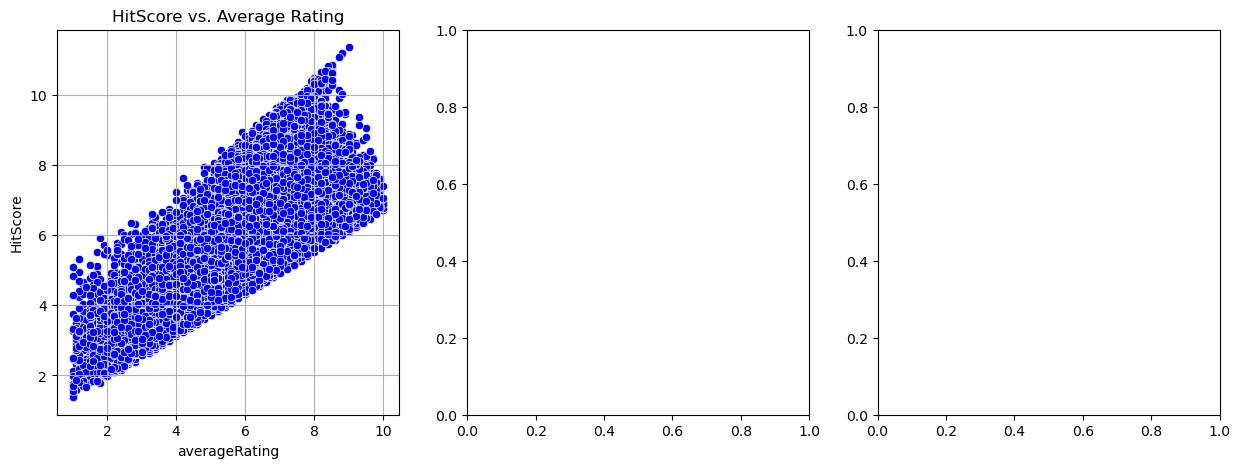

In [135]:
# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: HitScore vs averageRating
sns.scatterplot(x=df['averageRating'], y=df['HitScore'], ax=axes[0], color='b')
axes[0].set_title('HitScore vs. Average Rating')
axes[0].grid(True)

# Scatter plot: HitScore vs numVotes_log
sns.scatterplot(x=df['numVotes_log'], y=df['HitScore'], ax=axes[1], color='r')
axes[1].set_title('HitScore vs. NumVotes (log)')
axes[1].grid(True)  

# Scatter plot: averageRating vs numVotes_log
sns.scatterplot(x=df['averageRating'], y=df['numVotes_log'], ax=axes[2], color='g')
axes[2].set_title('Average Rating vs. NumVotes (log)')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df[['averageRating', 'numVotes_log', 'HitScore']].corr()
corr_matrix


### Unique Genres

In [31]:
unique_genres = df['genres'].str.split(',').explode().str.strip().unique()
print(unique_genres)

['Comedy' 'Romance' 'Action' 'Crime' 'Drama' 'Thriller' 'Adventure'
 'Horror' 'Mystery' 'Documentary' 'History' 'Unknown' 'Biography' 'Music'
 'Musical' 'Sci-Fi' 'War' 'Family' 'Fantasy' 'Animation' 'Sport' 'Western'
 'Adult' 'Reality-TV' 'News' 'Game-Show' 'Talk-Show']


## Format For Vanilla MLP

### Features and Target

In [82]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])


# **Define numerical & categorical features**
num_features = ['averageRating', 'numVotes_log']
cat_features = list(genre_columns)  # One-hot encoded genres

# Define features and target
# X = df[num_features].to_numpy()
X = df[num_features + cat_features].to_numpy()
y = df['HitScore'].to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"{X_train.shape[0] + X_test.shape[0] == df.shape[0]}")
# print(f"{X_train.shape[0] + X_test.shape[0] == df.iloc[:1000,:].shape[0]}")

True


### Normalize the dataset

In [33]:
# scalerX = StandardScaler()
# X_train_scaled = scalerX.fit_transform(X_train)  # Fit on training set
# X_test_scaled = scalerX.transform(X_test)

# **Apply StandardScaler ONLY on training set**
scalerX = StandardScaler()
X_train[:, :len(num_features)] = scalerX.fit_transform(X_train[:, :len(num_features)])  
X_test[:, :len(num_features)] = scalerX.transform(X_test[:, :len(num_features)])


scalerY = StandardScaler()
y_train_scaled = scalerY.fit_transform(y_train)  
y_test_scaled = scalerY.transform(y_test) 

### Convert to Tensors

In [34]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


# Check shapes
print(X_train.shape, y_train_scaled.shape)
print(X_test.shape, y_test_scaled.shape)

(129445, 29) (129445, 1)
(32362, 29) (32362, 1)


### Dataloaders

In [88]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc254548e30>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc25454a030>
Length of train dataloader: 2023 batches of 64
Length of test dataloader: 506 batches of 64


## Format for Sequential/Time Series

### Features and Target

In [69]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])


# **Define numerical & categorical features**
num_features = ['averageRating', 'numVotes_log']
cat_features = list(genre_columns)  # One-hot encoded genres

# Define features and target
# X= df[['averageRating', 'numVotes_log']].to_numpy()
X1 = df[num_features + cat_features].to_numpy()
y1 = df['HitScore'].to_numpy().reshape(-1,1)

# X1 = X1[:1000,:]
# y1 = y1[:1000,:]

# Split data into training (80%) and temp (20%)
X1_train, X_temp, y1_train, y_temp = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Further split temp (20%) into validation (10%) and test (10%)
X_val, X1_test, y_val, y1_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"{X1_train.shape[0] + X_val.shape[0] + X1_test.shape[0] == df.shape[0]}")
# print(f"{X1_train.shape[0] + X1_test.shape[0] + X_val.shape[0] == df.iloc[:1000,:].shape[0]}")

True


In [83]:
scalerX = StandardScaler()
X1_train[:,:len(num_features)] = scalerX.fit_transform(X1_train[:,:len(num_features)])
X1_test[:,:len(num_features)] = scalerX.transform(X1_test[:,:len(num_features)])
X_val[:,:len(num_features)] = scalerX.transform(X_val[:,:len(num_features)])
# X1_train_scaled = scalerX.fit_transform(X1_train)  # Fit on training set
# X1_test_scaled = scalerX.transform(X1_test)
# X_val_scaled = scalerX.transform(X_val[:,:len(num_features)])  # Apply on test set


scalerY = StandardScaler()
y1_train_scaled = scalerY.fit_transform(y1_train)  # Fit on training set
y1_test_scaled = scalerY.transform(y1_test)  # Apply on test set
y_val_scaled = scalerY.transform(y_val)  # Apply on validation test set

### Convert the data into a sequential type

In [84]:
# Define time step 
TIME_STEP = 3  

def create_sequences(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step]) 
        ys.append(y[i+time_step])    # Target is the next year
    return np.array(Xs), np.array(ys)

# Convert datasets into 3D shape (samples, time steps, features)
X_train_seq, y_train_seq = create_sequences(X1_train, y1_train, TIME_STEP)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, TIME_STEP)
X_test_seq, y_test_seq = create_sequences(X1_test, y1_test, TIME_STEP)

# Check shapes
print("Train shape:", X_train_seq.shape)  # (samples, time_steps, features)
print("Val shape:", X_val_seq.shape)
print("Test shape:", X_test_seq.shape)

Train shape: (129442, 3, 29)
Val shape: (16178, 3, 29)
Test shape: (16178, 3, 29)


### Convert to Tensors

In [86]:
# Convert to PyTorch tensors
X1_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
X1_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

y1_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
y1_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)


# Check shapes
print(X1_train_tensor.shape, y1_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)
print(X1_test_tensor.shape, y1_test_tensor.shape)

torch.Size([129442, 3, 29]) torch.Size([129442, 1])
torch.Size([16178, 3, 29]) torch.Size([16178, 1])
torch.Size([16178, 3, 29]) torch.Size([16178, 1])


### Use Dataloaders from PyTorch

In [87]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X1_train_tensor, y1_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X1_test_tensor, y1_test_tensor)

# Create DataLoaders
batch_size = 64 

train1_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False) 
test1_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train1_dataloader}\nTest dataloader: {test1_dataloader}")
print(f"Length of train dataloader: {len(train1_dataloader)} batches of {train1_dataloader.batch_size}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {val_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test1_dataloader)} batches of {test1_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc25877c0e0>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc258455cd0>
Length of train dataloader: 2023 batches of 64
Length of validation dataloader: 253 batches of 64
Length of test dataloader: 253 batches of 64


# Optimizer

In [41]:
#Adan: Adaptive Nesterov Momentum Algorithm

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

# Setup Device Agnostic Code

In [42]:
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
    !nvidia-smi
else:
    print(f"Number of cores: {os.cpu_count()}")

Device: cpu
Number of cores: 16


# Creating the Models

## CNN-LSTM

In [43]:
from torch import dropout


cnn_params = [8, 16, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=200, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=16, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 150),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(150, output_size)
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
            # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x


torch.manual_seed(25)
# Instantiate Model
model69 = MainModel(input_size=X1_train_tensor.shape[2], hidden_size=50, num_layers=3, output_size=1).to(device)

print(f"{model69}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model69.parameters())
print(f"Total number of parameters: {total_params}")


MainModel(
  (cnn): CNN1D(
    (conv_blocks): Sequential(
      (0): Conv1d(29, 8, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm): LSTM(16, 50, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=150, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)
Total number of parameters: 62993


## LSTM Only

In [72]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x: torch.Tensor, h0=None, c0=None):
        ##initialize hidden state
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x)
        return x
    
torch.manual_seed(25)
# Instantiate Model
model = MyModel(input_size=X1_train_tensor.shape[2], hidden_size=50, num_layers=3, output_size=1).to(device)

print(f"{model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

MyModel(
  (lstm): LSTM(29, 50, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
Total number of parameters: 59601


## Vanilla MLP

In [66]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=1000, output_size=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [51]:
device = "cpu"
dummy  = torch.randn(X_train_tensor.shape[0], X_train_tensor.shape[1])
model = MLP(input_size=X_train_tensor.shape[1], hidden_size=1000, output_size=1).to(device)
# print(model)
y_pred = model(dummy)

## Test on a Dummy Data

In [75]:
dummy = torch.randn(X1_train_tensor.shape[0], X1_train_tensor.shape[1], X1_train_tensor.shape[2])
# Test Forward Pass
# y = model(dummy)  # Testing with dummy training data
y = model69(X1_train_tensor)
print(f"{y.shape}")
print(f"{y}")

torch.Size([794, 1])
tensor([[-1.2953e-04],
        [-1.1509e-02],
        [-7.1656e-04],
        [-7.5603e-03],
        [-1.0319e-02],
        [-1.1686e-02],
        [-1.3755e-02],
        [ 1.0502e-02],
        [-1.5147e-02],
        [ 3.0908e-02],
        [-2.3833e-02],
        [ 2.8493e-02],
        [-1.9122e-02],
        [-2.4975e-02],
        [ 9.7851e-03],
        [-3.3165e-02],
        [-1.5183e-02],
        [-5.6570e-02],
        [ 1.1494e-02],
        [-1.5889e-03],
        [-4.4991e-02],
        [ 1.8766e-02],
        [-1.0120e-02],
        [ 1.1319e-02],
        [-2.7050e-02],
        [ 2.2851e-03],
        [-4.9629e-03],
        [-5.0069e-03],
        [-1.1531e-02],
        [-9.7184e-03],
        [-4.9935e-02],
        [ 1.3400e-02],
        [ 8.2975e-03],
        [ 1.4804e-03],
        [ 9.7261e-03],
        [-3.7053e-03],
        [-3.0202e-03],
        [-2.1085e-02],
        [ 2.0996e-02],
        [-3.5686e-02],
        [-1.1612e-02],
        [ 1.4371e-02],
        [-7.5

In [221]:
cnn_params = [16, 32, "MaxPool"]

class VGG1D(nn.Module):
    def __init__(self, input=1, output_shape=1):  # 1 input channel for time series
        super(VGG1D, self).__init__()
        self.input = input
        self.convolutional_blocks = self.create_convolutional_blocks(cnn_params) 

        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32 * 1 * 1, 128),  # Adjust based on feature map size
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, output_shape)
        )
    
    def forward(self, out):
        out = out.permute(0, 2, 1)  # (batch, time, features) -> (batch, features, time)
        out = self.convolutional_blocks(out)
        print(out.shape)  # Debug the CNN output shape!
        out = self.fc(out)
        return out
    
    def create_convolutional_blocks(self, architecture):
        layers = []
        input = self.input

        for k in architecture:
            if type(k) == int:
                output = k
                layers += [nn.Conv1d(input, output, kernel_size=3, stride=1, padding=1),
                           nn.ReLU()]
                input = k
            elif k == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)
    
model = VGG1D(input=X1_train_tensor.shape[0], output_shape=1)
print(model)


VGG1D(
  (convolutional_blocks): Sequential(
    (0): Conv1d(797, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): SiLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [220]:
dummy = torch.randn(X1_train_tensor.shape[0], X1_train_tensor.shape[1], X1_train_tensor.shape[2])
y = model(dummy)

y

torch.Size([797, 32, 1])


tensor([[-0.1159],
        [-0.1114],
        [-0.1171],
        [-0.1232],
        [-0.1053],
        [-0.1000],
        [-0.1177],
        [-0.1114],
        [-0.1184],
        [-0.1061],
        [-0.1045],
        [-0.1076],
        [-0.1098],
        [-0.1136],
        [-0.1135],
        [-0.1207],
        [-0.1124],
        [-0.1117],
        [-0.1079],
        [-0.1112],
        [-0.1263],
        [-0.1220],
        [-0.1151],
        [-0.1070],
        [-0.1142],
        [-0.1025],
        [-0.1149],
        [-0.1054],
        [-0.1145],
        [-0.1078],
        [-0.1132],
        [-0.1051],
        [-0.1140],
        [-0.1031],
        [-0.1163],
        [-0.1079],
        [-0.1175],
        [-0.1075],
        [-0.1072],
        [-0.1098],
        [-0.1133],
        [-0.1197],
        [-0.1072],
        [-0.1062],
        [-0.1157],
        [-0.1168],
        [-0.1137],
        [-0.1061],
        [-0.1088],
        [-0.1180],
        [-0.1171],
        [-0.1115],
        [-0.

## Define Train and Test functions for training

In [57]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training R2: {train_acc:.4f}")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test R2 {test_acc:5f}")
    return test_loss, test_acc

## Setup parameters, objective function, and r2 metric

In [78]:
from sklearn.metrics import r2_score
def calculate_accuracy(y_true, y_pred):
    """
    Computes an accuracy-like metric for regression using R^2 Score.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r2 = r2_score(y_true, y_pred)  # Best: 1, Worst: -∞
    return r2  # Treat as "accuracy" for regression

## Setup loss function
loss_fn = nn.MSELoss()

device = "cpu"
num_of_epochs = 50
num_loss_steps = 5
seed_number = 42
learning_rate = 0.001

# Train the Model

## Train CNN-LSTM

In [ ]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model = MainModel(input_size=X1_train_tensor.shape[2], 
                  hidden_size=50, num_layers=3, output_size=1).to(device)


optimizer= Adan(params=model.parameters(), 
                lr=0.0001, 
                betas=(0.94, 0.91, 0.999), 
                weight_decay=1e-2)

# optimizer = torch.optim.Adam(params=model.parameters(), 
#                               lr=0.001, 
#                               betas=(0.9,0.99),
#                               eps=1e-6,
#                               weight_decay=0.01)

results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);


  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 27.36445 | Training R2: -37.3382
Test Loss 20.72869 | Test R2 -25.411399
Epoch: 5 
Training Loss: 1.06575 | Training R2: -0.3171
Test Loss 0.86881 | Test R2 -0.060605
Epoch: 10 
Training Loss: 1.02135 | Training R2: -0.2606
Test Loss 0.86832 | Test R2 -0.059485
Epoch: 15 
Training Loss: 0.98218 | Training R2: -0.2121
Test Loss 0.86796 | Test R2 -0.059416
Epoch: 20 
Training Loss: 0.94702 | Training R2: -0.1696
Test Loss 0.86698 | Test R2 -0.059766
Epoch: 25 
Training Loss: 0.91101 | Training R2: -0.1264
Test Loss 0.86714 | Test R2 -0.063521
Epoch: 30 
Training Loss: 0.86816 | Training R2: -0.0738
Test Loss 0.88119 | Test R2 -0.087365
Epoch: 35 
Training Loss: 0.81905 | Training R2: -0.0124
Test Loss 0.92556 | Test R2 -0.149192
Epoch: 40 
Training Loss: 0.76864 | Training R2: 0.0476
Test Loss 0.98322 | Test R2 -0.223988
Epoch: 45 
Training Loss: 0.72604 | Training R2: 0.0971
Test Loss 1.02690 | Test R2 -0.275871
Total Runtime:  1.02


## Train LSTM

In [79]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)


model3 = MyModel(input_size=X1_train_tensor.shape[2],
                 hidden_size=20, num_layers=3, output_size=1).to(device)

optimizer= Adan(params=model3.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results2 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model3,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model3,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results2["train_loss"].append(train_loss)
  results2["train_accu"].append(train_accu)
  results2["test_loss"].append(test_loss)
  results2["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 


Training Loss: 37.57496 | Training R2: -24.5317
Test Loss 36.24074 | Test R2 -24.432827
Epoch: 5 
Training Loss: 2.49692 | Training R2: -0.6094
Test Loss 1.61001 | Test R2 -0.093339
Epoch: 10 
Training Loss: 2.41689 | Training R2: -0.5516
Test Loss 1.61928 | Test R2 -0.099688
Epoch: 15 
Training Loss: 2.36881 | Training R2: -0.5166
Test Loss 1.61801 | Test R2 -0.098733
Epoch: 20 
Training Loss: 2.31986 | Training R2: -0.4825
Test Loss 1.62097 | Test R2 -0.099293
Epoch: 25 
Training Loss: 2.26506 | Training R2: -0.4476
Test Loss 1.62388 | Test R2 -0.098533
Epoch: 30 
Training Loss: 2.22057 | Training R2: -0.4197
Test Loss 1.61364 | Test R2 -0.091817
Epoch: 35 
Training Loss: 2.17876 | Training R2: -0.3943
Test Loss 1.60279 | Test R2 -0.085104
Epoch: 40 
Training Loss: 2.14100 | Training R2: -0.3715
Test Loss 1.59518 | Test R2 -0.080613
Epoch: 45 
Training Loss: 2.10492 | Training R2: -0.3498
Test Loss 1.59001 | Test R2 -0.077729
Total Runtime:  3.50


## Train MLP

In [60]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model2 = MLP(input_size=X_train_tensor.shape[1], 
             hidden_size=600, output_size=1).to(device)

optimizer= Adan(params=model2.parameters(), 
                lr=0.0001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results1 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, 100)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model2,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model2,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results1["train_loss"].append(train_loss)
  results1["train_accu"].append(train_accu)
  results1["test_loss"].append(test_loss)
  results1["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 


Training Loss: 0.00965 | Training R2: 0.9893
Test Loss 0.00087 | Test R2 0.998998
Epoch: 10 
Training Loss: 0.00090 | Training R2: 0.9989
Test Loss 0.00015 | Test R2 0.999824
Epoch: 20 
Training Loss: 0.00044 | Training R2: 0.9994
Test Loss 0.00017 | Test R2 0.999797


KeyboardInterrupt: 